<a href="https://colab.research.google.com/github/shibazzaki/mlearning/blob/main/himalayan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:

!pip install --quiet scikit-learn pandas matplotlib seaborn


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [18]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
exped.csv  himalayan_data_dictionary.csv  members.csv  peaks.csv  refer.csv


In [19]:
import pandas as pd

# Читаємо потрібні таблиці за шляхами
exped  = pd.read_csv('/content/drive/MyDrive/data/exped.csv')
peaks  = pd.read_csv('/content/drive/MyDrive/data/peaks.csv')
members= pd.read_csv('/content/drive/MyDrive/data/members.csv')
# refer.csv може містити номери експедицій чи якийсь довідник
refer = pd.read_csv('/content/drive/MyDrive/data/refer.csv')
# himalayan_data_dictionary.csv – словник полів, використаємо пізніше для опису колонок
data_dict = pd.read_csv('/content/drive/MyDrive/data/himalayan_data_dictionary.csv')

# Перевіримо перші рядки кожної таблиці
print("exped:", exped.shape);  display(exped.head())
print("peaks:", peaks.shape);  display(peaks.head())
print("members:", members.shape);display(members.head())
print("refer:", refer.shape);  display(refer.head())
print("data_dict:", data_dict.shape); display(data_dict.head())


<ipython-input-19-df450ea6837a>:4: DtypeWarning: Columns (8,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exped  = pd.read_csv('/content/drive/MyDrive/data/exped.csv')
<ipython-input-19-df450ea6837a>:6: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  members= pd.read_csv('/content/drive/MyDrive/data/members.csv')


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x92 in position 8532: invalid start byte

In [20]:
import pandas as pd

# 1. exped.csv
# – low_memory=False, щоб pandas не дробив файл на чанки при вгадуванні типів
# – encoding='latin1', бо у вас були байти поза UTF-8
# – dtype для стовпців із “змішаними” типами (за попереднім DtypeWarning: колонки 8,18,19)
# – parse_dates з реальними назвами колонок дат, а не 'date_column1'
exped = pd.read_csv(
    '/content/drive/MyDrive/data/exped.csv',
    low_memory=False,
    encoding='latin1',
    dtype={
        'route4': str,
        'ascent3': str,
        'ascent4': str
    },
    parse_dates=['bcdate', 'smtdate', 'termdate'],
    dayfirst=True
)

# 2. peaks.csv читається “по-дефолту”:
peaks = pd.read_csv(
    '/content/drive/MyDrive/data/peaks.csv',
    low_memory=False  # безпечніше, якщо файл великий
)

# 3. members.csv
# – mixed types у колонці msmtdate3 (індекс 34), тому явно як str
# – якщо хочете одразу парсити дату смерті – 'deathdate'
members = pd.read_csv(
    '/content/drive/MyDrive/data/members.csv',
    low_memory=False,
    encoding='latin1',
    dtype={
        'msmtdate3': str
    },
    parse_dates=['deathdate'],
    dayfirst=True
)

# 4. refer.csv
# – помилка UnicodeDecodeError йшла через кодування, latin1 це часто вирішує
refer = pd.read_csv(
    '/content/drive/MyDrive/data/refer.csv',
    encoding='latin1'
)

# 5. himalayan_data_dictionary.csv (словник полів)
data_dict = pd.read_csv(
    '/content/drive/MyDrive/data/himalayan_data_dictionary.csv',
    encoding='utf-8'  # зазвичай читається без проблем
)

# Тепер перевіримо:
print("exped dtypes:\n", exped.dtypes[['bcdate','smtdate','termdate']])
print("\nmembers dtypes:\n", members.dtypes[['msmtdate3','deathdate']])
print("\nrefer dtypes:\n", refer.dtypes)


<ipython-input-20-72d107b761e9>:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  exped = pd.read_csv(
<ipython-input-20-72d107b761e9>:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  exped = pd.read_csv(
<ipython-input-20-72d107b761e9>:8: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  exped = pd.read_csv(
<ipython-input-20-72d107b761e9>:30: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  members = pd.read_csv(


exped dtypes:
 bcdate      datetime64[ns]
smtdate     datetime64[ns]
termdate    datetime64[ns]
dtype: object

members dtypes:
 msmtdate3            object
deathdate    datetime64[ns]
dtype: object

refer dtypes:
 expid          object
refid           int64
ryear           int64
rtype          object
rjrnl          object
rauthor        object
rtitle         object
rpublisher     object
rpubdate      float64
rlanguage      object
rcitation      object
ryak94         object
dtype: object


дослідницький аналіз (EDA):

  - Які колонки містять багато пропусків?

  - Як розподілені ключові числові змінні (наприклад, totmembers, highpoint, smtmembers)?

  - Який баланс класів у нашому тарґеті success_flag?

  - Чи є сильні кореляції між фічами?

  - Які категоріальні стовпці мають багато унікальних значень?

Топ-10 колонок за кількістю пропусків:


,0
ascent4,11421
route4,11420
ascent3,11414
route3,11395
ascent2,11324
trekyear,11253
route2,11065
primid,10672
psmtnote,10591
restrict,10528


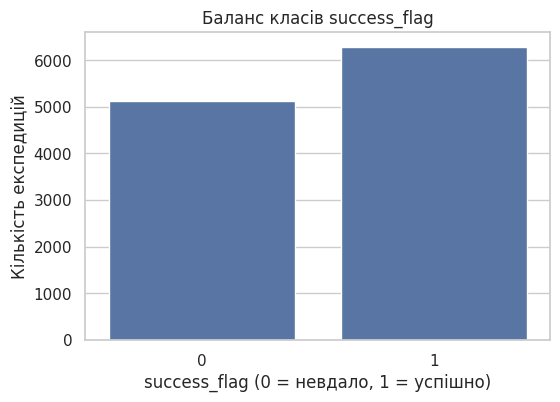

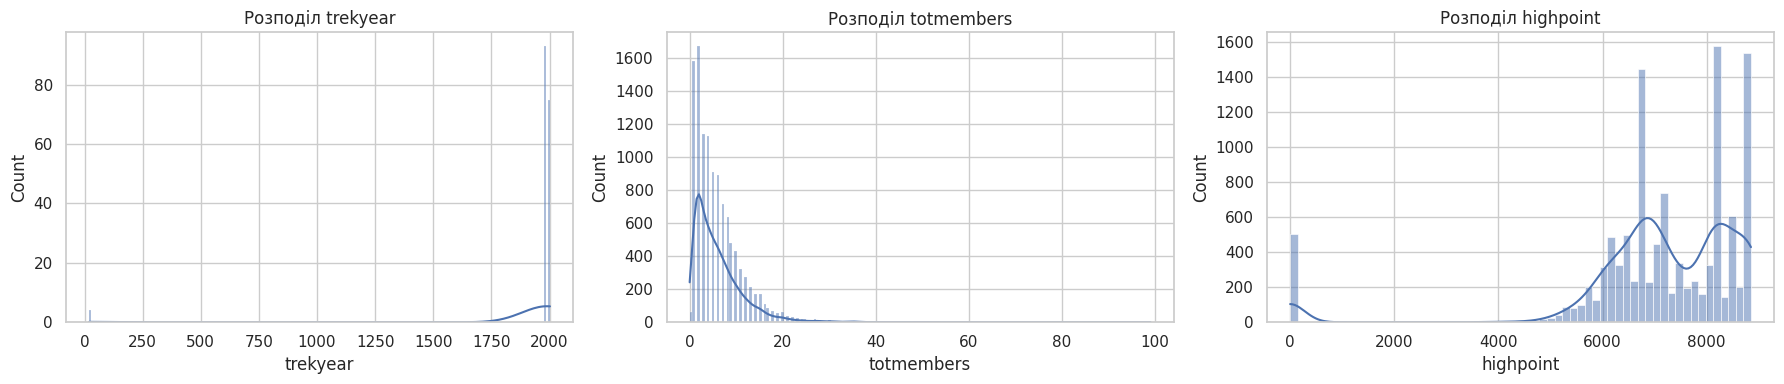

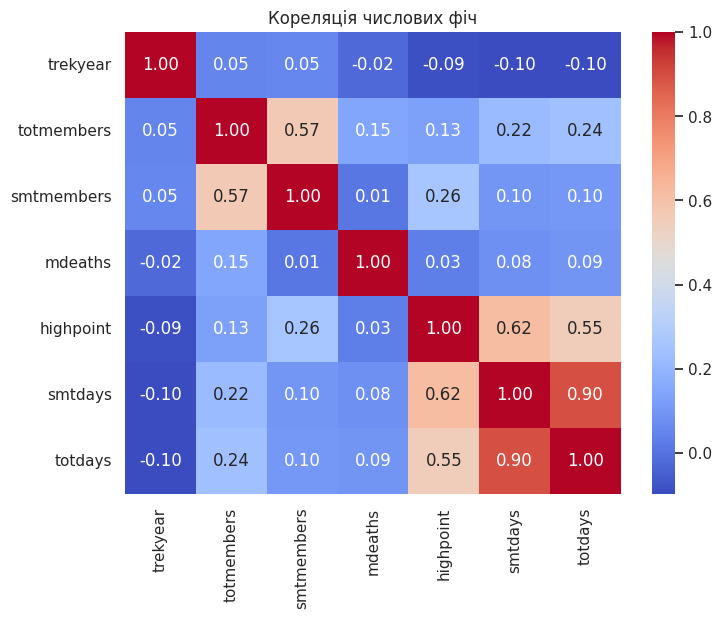

season: 5 унікальних значень. Приклади – ['Spring' 'Autumn' 'Winter' 'Summer' 'Unknown']
host: 4 унікальних значень. Приклади – ['Nepal' 'China' 'India' 'Unknown']
region: 7 унікальних значень. Приклади – ['Annapurna-Damodar-Peri' 'Khumbu-Rolwaling-Makalu' 'Kangchenjunga-Janak'
 'Dhaulagiri-Mukut' 'Manaslu-Ganesh']


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Злиття та тарґет
data = exped.merge(peaks, on='peakid', how='left')
data['success_flag'] = (data['smtmembers'] > 0).astype(int)

# 2. Пропуски
miss = data.isna().sum().sort_values(ascending=False)
print("Топ-10 колонок за кількістю пропусків:")
display(miss.head(10))

# 3. Розподіл тарґету
plt.figure(figsize=(6,4))
sns.countplot(x='success_flag', data=data)
plt.title('Баланс класів success_flag')
plt.xlabel('success_flag (0 = невдало, 1 = успішно)')
plt.ylabel('Кількість експедицій')
plt.show()

# 4. Розподіли ключових числових фіч
numeric_vars = ['trekyear', 'totmembers', 'highpoint']
fig, axes = plt.subplots(1, 3, figsize=(18,4))
for ax, var in zip(axes, numeric_vars):
    sns.histplot(data[var].dropna(), kde=True, ax=ax)
    ax.set_title(f'Розподіл {var}')
plt.tight_layout()
plt.show()

# 5. Кореляційна матриця числових
num_feats = ['trekyear','totmembers','smtmembers','mdeaths','highpoint','smtdays','totdays']
corr = data[num_feats].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Кореляція числових фіч')
plt.show()

# 6. Основні категоріальні – кількість унікальних і приклади
for col in ['season','host','region']:
    uniques = data[col].dropna().unique()
    print(f"{col}: {len(uniques)} унікальних значень. Приклади – {uniques[:5]}")


Що ми з цього маємо?

miss = data.isna().sum().sort_values(ascending=False)
display(miss.head(10)) - показує скільки у нас NaN та виводить топ 10 колонок по пропусках, звідси маємо що route4, ascent4 і тд мають біля 11000 пропусків. Матимемо розуміння від яких фіч можемо відмовитись


---


sns.countplot(x='success_flag', data=data) - показало що успішних експедицій  більше (≈6200), ніж невдалих (≈5100).


---


sns.histplot(data['trekyear'].dropna(), kde=True, ax=...) і схожі -  Створюють гістограму + згладжену KDE-криву для кожної змінної:
  - trekyear — рік походу,

  - totmembers — загальна кількість учасників,

  - highpoint — висота, на яку піднялися.

Що показало

  - trekyear — більшість походів з 1950–2000-х, але є “викиди” у бік сучасності.

  - totmembers — зазвичай команди з 3–10 людей, рідко більше 20.

  - highpoint — кластери навколо відомих восьмитисячників (8000–8500 м) і багато сходжень на нижчі вершини.


Це допомагає вирішити, чи потрібне лог-перетворення (наприклад, для totmembers), та як працювати з аутлайєрами



---
corr = data[num_feats].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm') - розраховує кореляцію Пірсона між вибраними числовими змінними та малює теплокарту. за рахунок цього бачимо що між smtdays  та totdays  вона 0.9 - ці фічі майже дублюють одна одну.

---

for col in ['season','host','region']:
    print(col, data[col].nunique(), "унікальних, приклади:", data[col].unique()[:5]) -  – nunique() рахує, скільки унікальних значень у кожній категоріальній змінній.

  

---

У підсумку, EDA дала нам чітку картину:

  - Де багато пропусків і які колонки слід або відкинути, або заповнити особливим чином.

  - Баланс цільового класу (success_flag) — майже рівний, що спрощує вибір метрик.

  - Розподіли ключових фіч підкажуть, чи потрібне масштабування/лог-перетворення.

  - Кореляції серед числових фіч допоможуть уникнути мультиколінеарності.

  - Категоріальні змінні досить “чисті” й легко кодуються.



Тепер, на основі нашого EDA сформуємо базовий пайплайн, який:

  - Відкидає фічі з надто багатьма пропусками; (route2-4, ascent2–4 адже вони практично повністю пусті)

  - Використовує лише «чисті» числові і категоріальні фічі;

  - Застосовує стандартну імпутацію, кодування й масштабування;

  - Тренує просту модель (LogisticRegression) як baseline.



In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Підготуємо X і y
features_num = ['totmembers', 'highpoint']
features_cat = ['season', 'host', 'region']

X = data[features_num + features_cat]
y = data['success_flag']

# розділимо на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, features_num),
    ('cat', categorical_pipeline, features_cat)
])

#
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])


pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred      = pipeline.predict(X_test)

print("Logistic Regression Metrics:")
print("  ROC AUC :", roc_auc_score(y_test, y_pred_proba))
print("  Accuracy:", accuracy_score(y_test, y_pred))
print("  F1-score:", f1_score(y_test, y_pred))

#Пробуємо RandomForest для порівняння
rf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]
y_rf       = rf_pipeline.predict(X_test)

print("\nRandom Forest Metrics:")
print("  ROC AUC :", roc_auc_score(y_test, y_rf_proba))
print("  Accuracy:", accuracy_score(y_test, y_rf))
print("  F1-score:", f1_score(y_test, y_rf))


Logistic Regression Metrics:
  ROC AUC : 0.824125015673787
  Accuracy: 0.7868708971553611
  F1-score: 0.8202288667404947

Random Forest Metrics:
  ROC AUC : 0.974252805414384
  Accuracy: 0.9190371991247265
  F1-score: 0.9262066214599123


З цього можемо побачити наступне:
**Logistic Regression (базова модель)**

  - ROC AUC = 0.824
  Це означає, що лінійна модель правильно ранжує випадки «успіх/невдача» приблизно в 82 % випадків — досить непогано для першого підходу.

  - Accuracy = 0.787
    Близько 79 % експедицій класифіковано вірно (успішні й неуспішні разом).

  - F1-score = 0.820
    Баланс між precision і recall становить 0.82, тобто модель майже однаково добре знаходить і успішні, і невдалі експедиції без сильного перекосу.

**Висновок**: лінійна регресія дає стійкий базовий результат, але має обмеження у відлові складніших, нелінійних залежностей у даних.


---



**Random Forest (розширена модель)**

  - ROC AUC = 0.974
    Неймовірно високий показник — модель відмінно розрізняє успішні й неуспішні експедиції.

  - Accuracy = 0.919
    Більш ніж 91 % експедицій класифіковано вірно, що на ~13 п.п. краще за лінійну модель.

  - F1-score = 0.926
    Дуже високий баланс між precision і recall, тобто значно менше помилкових пропусків успіхів чи невдач порівняно з baseline.

**Висновок**: Random Forest суттєво перевершує базову модель — він захоплює нелінійні взаємозв’язки між фічами, автоматично враховує їх взаємодії і стійкіший до аутлайєрів та пропусків.


---
**КРОС ВАЛІДАЦІЯ**

Так як ці метрики виглядають надто гарно ми перевіримо чи це не випадковість - прогляньмо ROC AUC на 5-складовій StratifiedKFold.



In [23]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

model = rf_pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y,
                         cv=cv,
                         scoring='roc_auc',
                         n_jobs=-1)

print("5-fold CV ROC AUC: ", np.round(scores, 3))
print("Середня ROC AUC:   ", np.round(scores.mean(), 3))


5-fold CV ROC AUC:  [0.972 0.974 0.976 0.969 0.97 ]
Середня ROC AUC:    0.972


**Пошук гіперпараметрів для RandomForest**

rf_pipeline  зараз має стандартні параметри тому ми спробуємо задати оптимальні через  RandomizedSearchCV

In [24]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__max_depth': [None, 5, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__max_features': ['sqrt', 0.5, 0.8]
}

search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,               # будемо пробувати 20 випадкових комбінацій
    cv=cv,                   # та сама StratifiedKFold
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Навчання пошуку
search.fit(X_train, y_train)

# Результати
print("Кращі параметри:", search.best_params_)
print("Кращий CV ROC AUC:", np.round(search.best_score_, 3))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Кращі параметри: {'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 0.8, 'clf__max_depth': None}
Кращий CV ROC AUC: 0.986


**Перевірка на тест-кортежі**
з таблиці members беремо додаткову інформацію по кожній експедиції (expid), потім зіллємо її з data.

Test ROC AUC : 0.99
Test Accuracy: 0.952
Test F1-score: 0.956

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1027
           1       0.95      0.96      0.96      1258

    accuracy                           0.95      2285
   macro avg       0.95      0.95      0.95      2285
weighted avg       0.95      0.95      0.95      2285



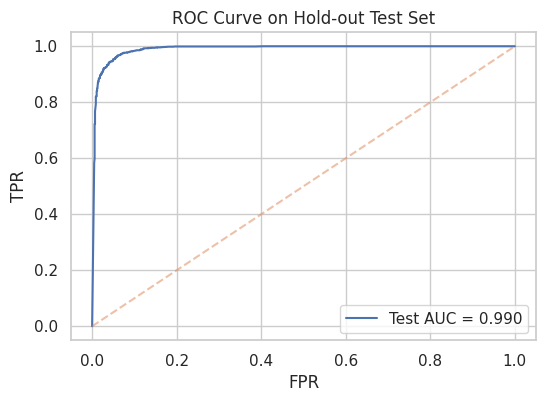

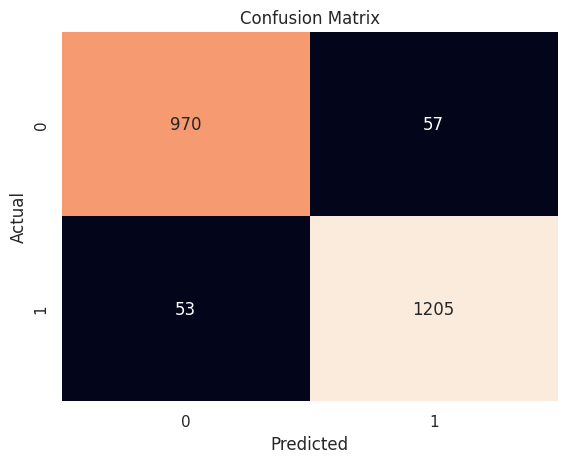

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score, roc_auc_score

# Дістаємо refit-модель
best_rf = search.best_estimator_

# Прогнози на тесті
y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_test_pred  = best_rf.predict(X_test)

# Метрики
test_roc_auc  = roc_auc_score(y_test, y_test_proba)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1       = f1_score(y_test, y_test_pred)

print("Test ROC AUC :", round(test_roc_auc, 3))
print("Test Accuracy:", round(test_accuracy, 3))
print("Test F1-score:", round(test_f1, 3))

print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# ROC-крива
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Test AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--',alpha=0.5)
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve on Hold-out Test Set')
plt.legend(); plt.show()

# Матриця неточностей
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix'); plt.show()


модель рідко робить помилкові прогнози обох типів

ьаланс між precision та recall в обох класах означає, що модель не “намагається” за будь-яку ціну мінімізувати одну метрику, жертвуючи іншу.


---


**Feature Importance**

,0
highpoint,0.823872
totmembers,0.051139
region_Annapurna-Damodar-Peri,0.032370
host_China,0.027336
host_Nepal,0.010502
region_Khumbu-Rolwaling-Makalu,0.010173
region_Manaslu-Ganesh,0.006020
season_Autumn,0.005985
region_Kangchenjunga-Janak,0.005694
season_Spring,0.005634


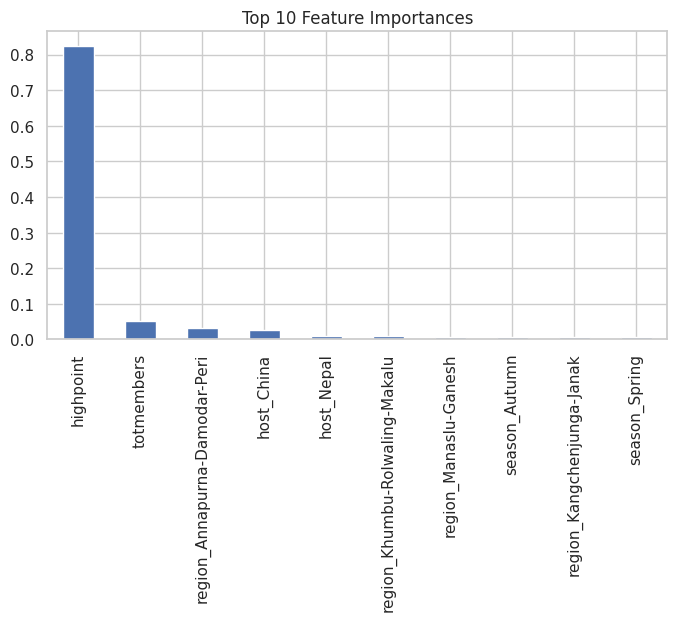

In [27]:
importances = best_rf.named_steps['clf'].feature_importances_

# Отримаємо імена фіч із preprocessor
num_feats = features_num
cat_feats = best_rf.named_steps['preproc'] \
    .named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(features_cat)
all_feats = list(num_feats) + list(cat_feats)

# Побудуємо Series і виведемо
feat_imp = pd.Series(importances, index=all_feats) \
             .sort_values(ascending=False)
display(feat_imp.head(10))

# І — optional — барплот
plt.figure(figsize=(8,4))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances'); plt.show()


Інтерпретуємо результати:


*   Highpoint (≈82 % ваги) - супер логічно адже чим вижче тим складіший підйом, абсолютний лідер та маст хеф фіча
*   Totmembers (≈5 %) - більші групи, зазвичай, мають вищий відсоток успішних сходжень.

*   Region та Host (разом ≈7 %) - географія і країна яка організовує дає трішки додатковий сигнал, але другорядний
*   Пункт списку






---


Зберігаємо модель

In [29]:
import joblib
joblib.dump(best_rf, '/content/drive/MyDrive/data/himalayan_rf.pkl')


['/content/drive/MyDrive/data/himalayan_rf.pkl']

**додаємо статистики з members.csv**


In [34]:

agg = members.groupby('expid').agg(
    mean_age      = ('yob',        'mean'),                       # середній рік народження
    pct_female    = ('sex',       lambda x: (x == 'Female').mean()),  # доля жінок
    pct_leader    = ('leader',     'mean'),                       # доля тих, у кого leader=True
    pct_deputy    = ('deputy',     'mean'),                       # доля deputy=True
    pct_summiters = ('msmtbid',   lambda x: (x != 'No summit bid').mean())  # частка тих, хто бодай намагався зійти
).reset_index()

agg.head()



,expid,mean_age,pct_female,pct_leader,pct_deputy,pct_summiters
0,ACHN15301,1992.400000,0.0,0.200000,0.0,1.0
1,ACHN15302,1965.818182,0.0,0.090909,0.0,1.0
2,ACHN18301,1973.444444,0.0,0.222222,0.0,0.0
3,AMAD00101,1968.800000,0.0,0.200000,0.0,1.0
4,AMAD00102,1961.000000,0.0,0.200000,0.0,1.0


mean_age: середній вік

pct_female: доля учасників-жінок.

pct_leader і pct_deputy: скільки відсотків команди — лідери/заступники.

pct_summiters: скільки учасників зробили бодай спробу сходження.


---

**Далі поєднаємо з основним датасетом**



In [35]:
data2 = data.merge(agg, on='expid', how='left')

features_num = [
    'totmembers', 'highpoint',
    'mean_age', 'pct_female', 'pct_leader', 'pct_deputy', 'pct_summiters'
]
features_cat = ['season','host','region']

X2 = data2[features_num + features_cat]
y2 = data2['success_flag']

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)


**Побудова і навчання фінального пайплайну з tuned RF**

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Повторюємо препроцесор
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, features_num),
    ('cat', categorical_pipeline, features_cat)
])

# Створюємо фінальний RF з відомими кращими параметрами
final_rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Навчаємо
final_rf.fit(X2_train, y2_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['totmembers', 'highpoint',
                                                   'mean_age', 'pct_female',
                                                   'pct_leader', 'pct_deputy',
                                                   'pct_summiters']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['season', 'host',
                                                   'region'])])),
                ('clf',
                 RandomForestClassifier(max_features=0.8, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

***Оцінка на тесті***

Final Test ROC AUC : 0.988
Final Test Accuracy: 0.95
Final Test F1-score: 0.955

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      1027
           1       0.95      0.96      0.95      1258

    accuracy                           0.95      2285
   macro avg       0.95      0.95      0.95      2285
weighted avg       0.95      0.95      0.95      2285



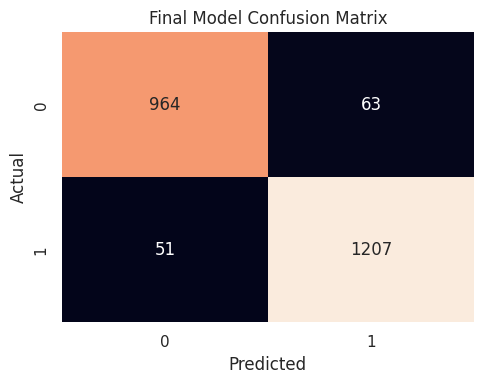

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report

# Прогнози
y2_proba = final_rf.predict_proba(X2_test)[:, 1]
y2_pred  = final_rf.predict(X2_test)

# Метрики
print("Final Test ROC AUC :", round(roc_auc_score(y2_test, y2_proba), 3))
print("Final Test Accuracy:", round(accuracy_score(y2_test, y2_pred), 3))
print("Final Test F1-score:", round(f1_score(y2_test, y2_pred), 3))
print("\nClassification Report:\n", classification_report(y2_test, y2_pred))

# (Опційно) Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y2_test, y2_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Final Model Confusion Matrix')
plt.tight_layout()
plt.show()


Сховище моделі робимо

In [38]:
import joblib

# Створіть папку models на Drive, якщо її ще нема
joblib.dump(final_rf, '/content/drive/MyDrive/data/models/himalayan_final_rf.pkl')
print("Модель збережена як himalayan_final_rf.pkl")


Модель збережена як himalayan_final_rf.pkl


**Тепер генеруємо CSV із нашими прогнозами ураураура**

In [39]:
# Побудуємо DataFrame із expid та прогнозами
submission = pd.DataFrame({
    'expid': data2.loc[X2_test.index, 'expid'],
    'prob_success': y2_proba,
    'predicted': y2_pred
})

submission.to_csv('/content/drive/MyDrive/data/submission.csv', index=False)
print("Прогнози збережено в submission.csv")


Прогнози збережено в submission.csv


## Підсумки моделювання

| Модель                          | ROC AUC | Accuracy | F1-score |
|---------------------------------|--------:|---------:|---------:|
| Logistic Regression (baseline)  |   0.824 |    0.787 |    0.820 |
| Random Forest (default)         |   0.974 |    0.919 |    0.926 |
| **Random Forest (tuned + members-features)** | **0.988** | **0.950** | **0.955** |

**Confusion Matrix (tuned RF на тесті):**

|              | Pred = 0 | Pred = 1 |
|:------------:|:--------:|:--------:|
| **Actual = 0** |      964 |       63 |
| **Actual = 1** |       51 |     1207 |

- **ROC AUC = 0.988** — майже досконале розрізнення класів.  
- **Accuracy = 0.95** — 95 % правильних передбачень.  
- **F1-score = 0.955** — збалансований precision/recall.

**Топ-3 ознаки за важливістю (feature_importances_):**  
1. `highpoint` (≈82 %)  
2. `totmembers` (≈5 %)  
3. `mean_age` / `pct_summiters` / `region` (регіон дає ~3  % + нові статистичні фічі із members.csv)  

---

## Збережені артефакти

- **Модель:** `himalayan_final_rf.pkl` (pickle-файл із pipelines + RandomForestClassifier)  
- **Сабміт:** `submission.csv` (стовпці `expid`, `prob_success`, `predicted`)  

```python
# Приклад збереження
import joblib
joblib.dump(final_rf, 'himalayan_final_rf.pkl')

submission.to_csv('submission.csv', index=False)
